In [87]:
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [88]:
l1 = sc.read_h5ad(
    filename="/home/sources/samples_alt_trv/L1/L1_L00_filtered.h5ad"
)
l2 = sc.read_h5ad(
    filename="/home/sources/samples_alt_trv/L2/L2_L00_filtered.h5ad"
)

## Check virus

In [89]:
virus_genes = {'TRV': ['TRV-PDS3-transcript', 'pVS1-StaA', 'pVS1-RepA', 'TRV-KanR', 'TRV-dGAG-transcript']}

marker_genes_in_data_l1 = dict()
for ct, markers in virus_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in l1.var.index:
            markers_found.append(marker)
    marker_genes_in_data_l1[ct] = markers_found

marker_genes_in_data_l2 = dict()
for ct, markers in virus_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in l2.var.index:
            markers_found.append(marker)
    marker_genes_in_data_l2[ct] = markers_found

In [90]:
print(marker_genes_in_data_l1) # yay! they are present 
print(marker_genes_in_data_l2)

{'TRV': ['TRV-PDS3-transcript', 'pVS1-StaA', 'pVS1-RepA', 'TRV-KanR', 'TRV-dGAG-transcript']}
{'TRV': ['TRV-PDS3-transcript', 'pVS1-StaA', 'pVS1-RepA', 'TRV-KanR', 'TRV-dGAG-transcript']}


In [91]:
print(l1.n_obs)
print(l1[l1[: , 'TRV-PDS3-transcript'].X > 0, :].n_obs) # count infected cells
print(l1[l1[: , 'TRV-dGAG-transcript'].X > 0, :].n_obs) # count infected cells

4305
127
0


In [92]:
print(l2.n_obs)
print(l2[l2[: , 'TRV-PDS3-transcript'].X > 0, :].n_obs) # count infected cells
print(l2[l2[: , 'TRV-dGAG-transcript'].X > 0, :].n_obs) # count infected cells

2629
0
45


In [94]:
l2 = l2[l2[: , 'TRV-dGAG-transcript'].X == 0, :].copy()
l2.n_obs

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


2584

# Check QC

In [95]:
# mitochondrial genes
l1.var["mt"] = l1.var_names.str.startswith("ATMG") #arabidopsis mt genome
l2.var["mt"] = l2.var_names.str.startswith("ATMG")
l1.var["cp"] = l1.var_names.str.startswith("ATCG") #arabidopsis cp genome
l2.var["cp"] = l2.var_names.str.startswith("ATCG")

# ribosomal genes - nuclear
l1.var["ribo"] = l1.var_names.str.startswith(("AT2G01010", "AT2G01020", 'AT3G41768', 'AT3G41979'))
l2.var["ribo"] = l2.var_names.str.startswith(("AT2G01010", "AT2G01020", 'AT3G41768', 'AT3G41979'))


sc.pp.calculate_qc_metrics(
    l1, qc_vars=["mt", 'cp', 'ribo'], inplace=True, percent_top=[20], log1p=True
)
sc.pp.calculate_qc_metrics(
    l2, qc_vars=["mt", 'cp', 'ribo'], inplace=True, percent_top=[20], log1p=True
)
l1

AnnData object with n_obs × n_vars = 4305 × 68069
    obs: 'n_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_cp', 'log1p_total_counts_cp', 'pct_counts_cp', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'mt', 'cp', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Text(0.5, 1.0, 'L2 counts')

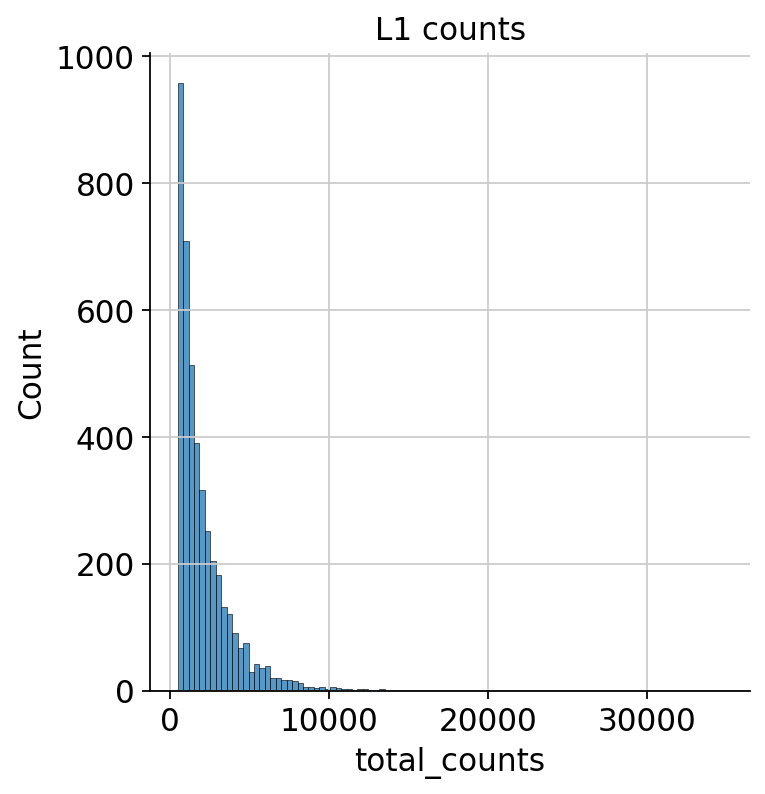

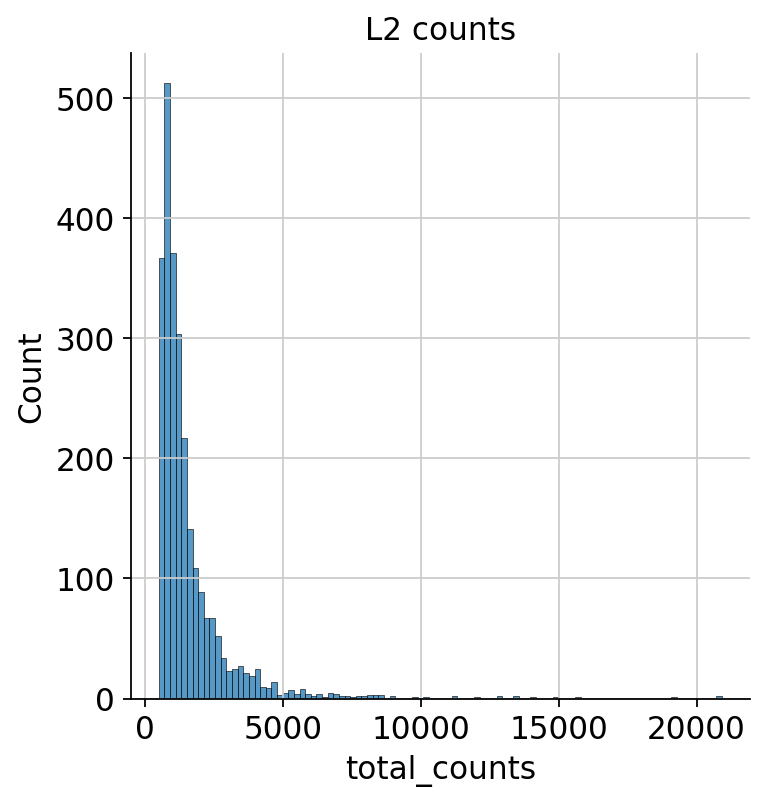

In [96]:
sns.displot(l1.obs["total_counts"], bins=100, kde=False)
plt.title('L1 counts')
sns.displot(l2.obs["total_counts"], bins=100, kde=False)
plt.title('L2 counts')

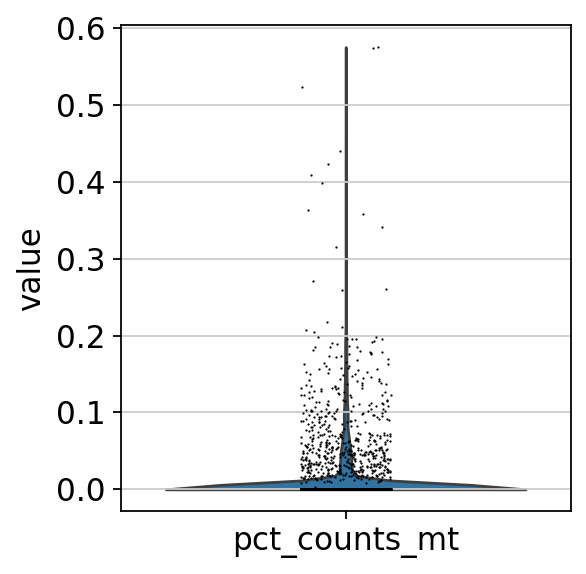

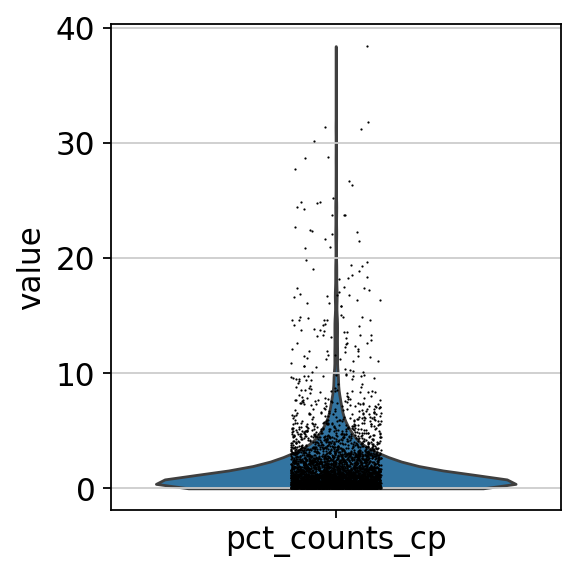

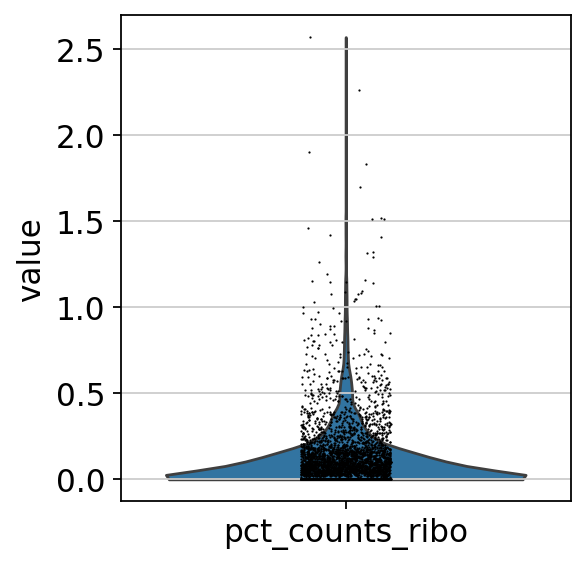

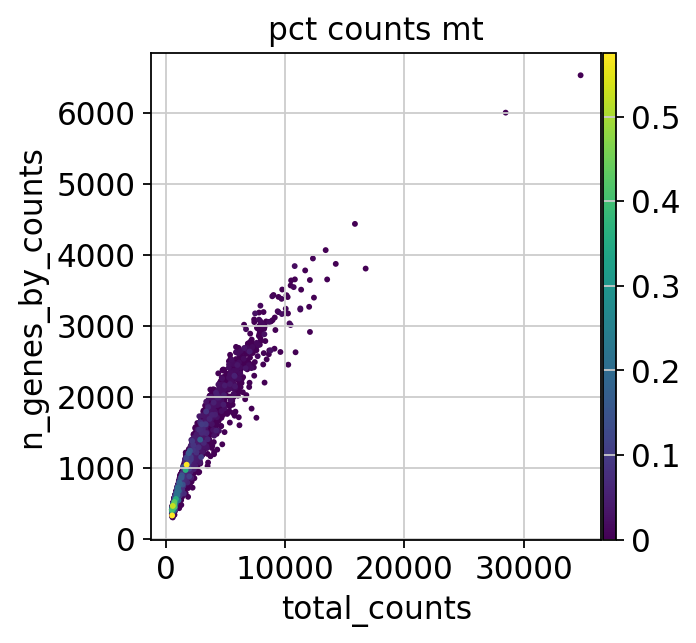

In [97]:
sc.pl.violin(l1, "pct_counts_mt")
sc.pl.violin(l1, "pct_counts_cp")
sc.pl.violin(l1, "pct_counts_ribo")
sc.pl.scatter(l1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


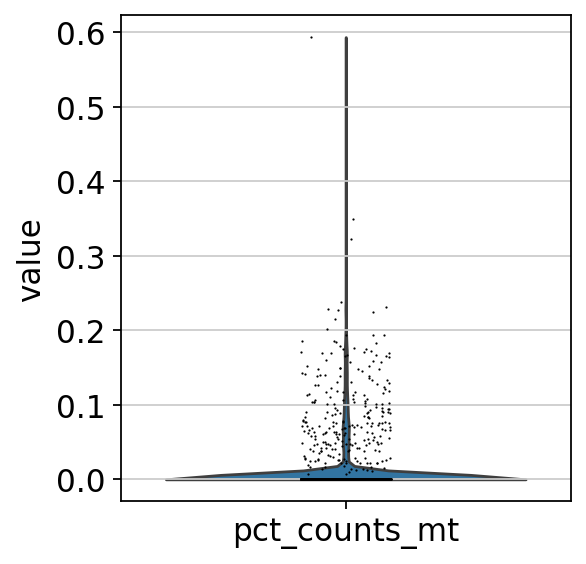

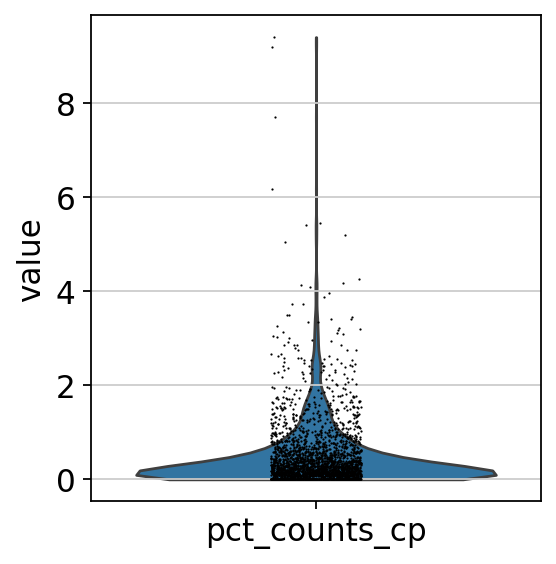

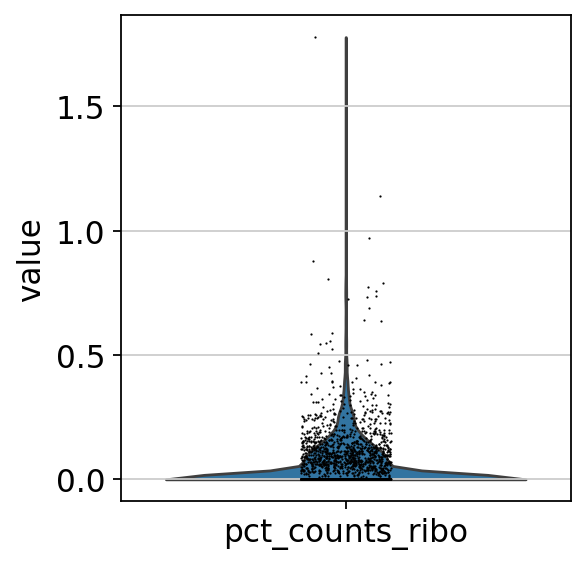

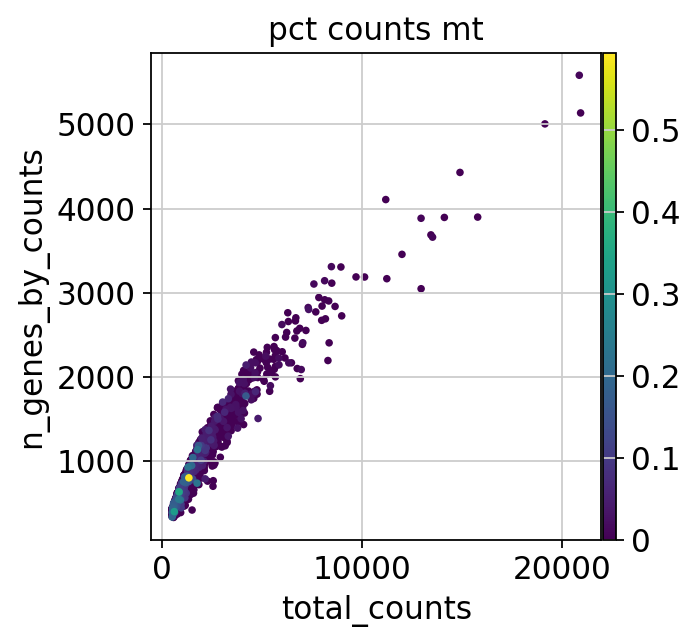

In [98]:
sc.pl.violin(l2, "pct_counts_mt")
sc.pl.violin(l2, "pct_counts_cp")
sc.pl.violin(l2, "pct_counts_ribo")
sc.pl.scatter(l2, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

The percentage of mitochondrial and ribosomal rna is really low

In [99]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [100]:
l1.obs["outlier"] = (
    is_outlier(l1, "log1p_total_counts", 6)
    | is_outlier(l1, "log1p_n_genes_by_counts", 6)
    | is_outlier(l1, "pct_counts_in_top_20_genes", 6)
)
l1.obs.outlier.value_counts()

outlier
False    4243
True       62
Name: count, dtype: int64

In [101]:
l2.obs["outlier"] = (
    is_outlier(l2, "log1p_total_counts", 6)
    | is_outlier(l2, "log1p_n_genes_by_counts", 6)
    | is_outlier(l2, "pct_counts_in_top_20_genes", 6)
)
l2.obs.outlier.value_counts()

outlier
False    2539
True       45
Name: count, dtype: int64

In [102]:
l1.obs["mt_outlier"] = (
    l1.obs["pct_counts_mt"] > 0.5 # outlier detection does not work well for median ~ 0
)
l1.obs.mt_outlier.value_counts()

mt_outlier
False    4302
True        3
Name: count, dtype: int64

In [103]:
l2.obs["mt_outlier"] = (
    l2.obs["pct_counts_mt"] > 0.5
)
l2.obs.mt_outlier.value_counts()

mt_outlier
False    2583
True        1
Name: count, dtype: int64

In [110]:
l1.obs["cp_outlier"] = (
    l1.obs["pct_counts_cp"] > 15
)
l1.obs.cp_outlier.value_counts()

cp_outlier
False    4250
True       55
Name: count, dtype: int64

In [111]:
l2.obs["cp_outlier"] = (
    l2.obs["pct_counts_cp"] > 15
)
l2.obs.cp_outlier.value_counts()

cp_outlier
False    2584
Name: count, dtype: int64

In [112]:
print(f"Total number of cells: {l1.n_obs}")
l1 = l1[(~l1.obs.outlier) & (~l1.obs.mt_outlier) & (~l1.obs.cp_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {l1.n_obs}")

Total number of cells: 4305
Number of cells after filtering of low quality cells: 4214


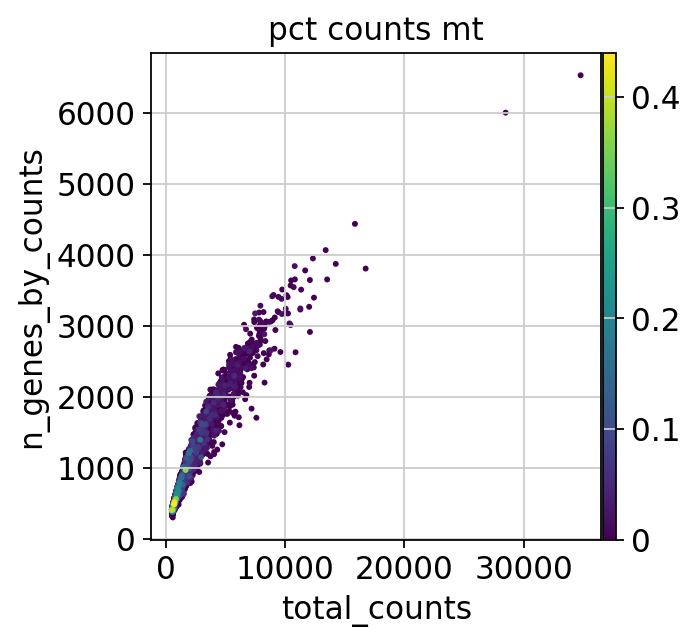

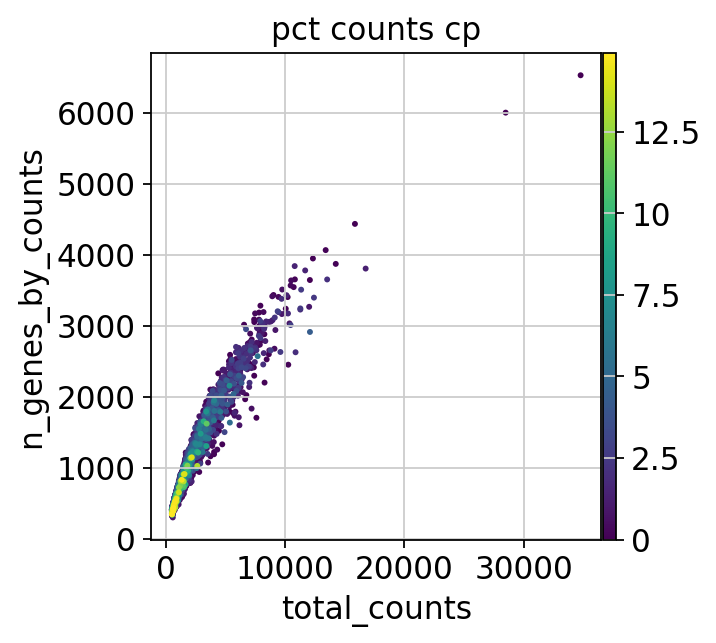

In [113]:
sc.pl.scatter(l1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(l1, "total_counts", "n_genes_by_counts", color="pct_counts_cp")

In [114]:
print(f"Total number of cells: {l2.n_obs}")
l2 = l2[(~l2.obs.outlier) & (~l2.obs.mt_outlier) & (~l2.obs.cp_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {l2.n_obs}")

Total number of cells: 2584
Number of cells after filtering of low quality cells: 2538


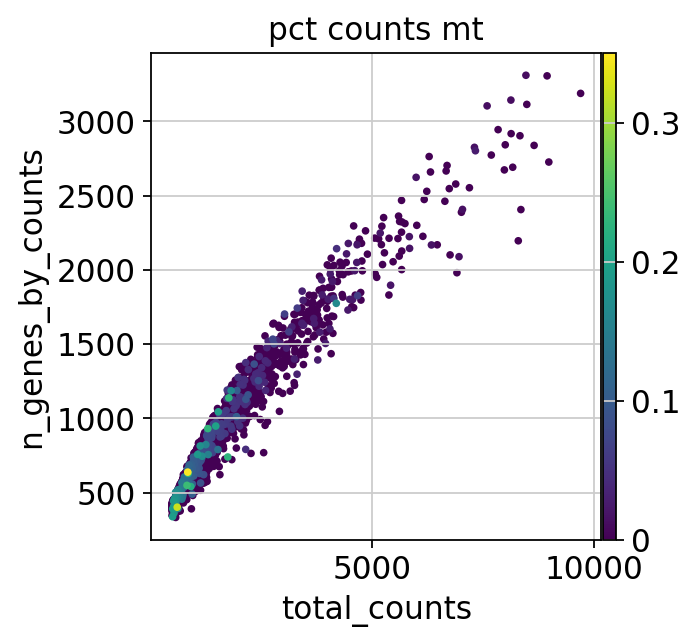

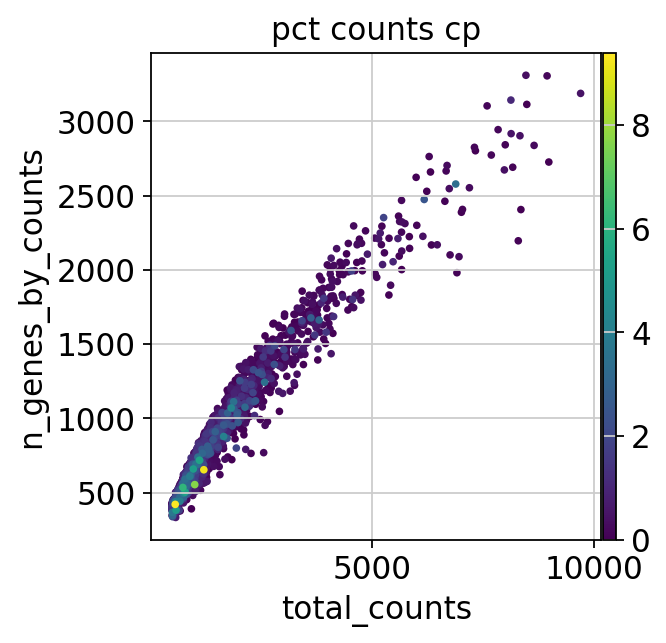

In [115]:
sc.pl.scatter(l2, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(l2, "total_counts", "n_genes_by_counts", color="pct_counts_cp")

# Ambient RNA

In [116]:
import anndata2ri
import logging
import os

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [117]:
%%R
library(SoupX)

In [118]:
l1_raw = sc.read_10x_mtx(
    path="/home/sources/samples_alt_trv/L1/raw_cell_gene_matrix"
)
l1_tod = l1_raw.X.T
l2_raw = sc.read_10x_mtx(
    path="/home/sources/samples_alt_trv/L2/raw_cell_gene_matrix"
)
l2_tod = l2_raw.X.T

In [119]:
del l1_raw
del l2_raw

In [120]:
l1_pp = l1.copy()
sc.pp.normalize_per_cell(l1_pp)
sc.pp.log1p(l1_pp)
l2_pp = l2.copy()
sc.pp.normalize_per_cell(l2_pp)
sc.pp.log1p(l2_pp)

In [121]:
sc.pp.pca(l1_pp)
sc.pp.neighbors(l1_pp)
sc.tl.leiden(l1_pp, key_added="soupx_groups")
sc.pp.pca(l2_pp)
sc.pp.neighbors(l2_pp)
sc.tl.leiden(l2_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups_l1 = l1_pp.obs["soupx_groups"]
soupx_groups_l2 = l2_pp.obs["soupx_groups"]

In [122]:
del l1_pp
del l2_pp

In [123]:
cells_l1 = l1.obs_names
genes_l1 = l1.var_names
data_l1 = l1.X.T
cells_l2 = l2.obs_names
genes_l2 = l2.var_names
data_l2 = l2.X.T

In [124]:
%%R -i data_l1 -i l1_tod -i genes_l1 -i cells_l1 -i soupx_groups_l1 -o out_l1 

# specify row and column names of data
rownames(data_l1) = genes_l1
colnames(data_l1) = cells_l1
# ensure correct sparse format for table of counts and table of droplets
data_l1 <- as(data_l1, "sparseMatrix")
l1_tod <- as(l1_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(l1_tod, data_l1, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data_l1), est = rowSums(data_l1)/sum(data_l1), counts = rowSums(data_l1))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups_l1)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out_l1 = adjustCounts(sc, roundToInt = TRUE)

In [125]:
%%R -i data_l2 -i l2_tod -i genes_l2 -i cells_l2 -i soupx_groups_l2 -o out_l2 

# specify row and column names of data
rownames(data_l2) = genes_l2
colnames(data_l2) = cells_l2
# ensure correct sparse format for table of counts and table of droplets
data_l2 <- as(data_l2, "sparseMatrix")
l2_tod <- as(l2_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(l2_tod, data_l2, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data_l2), est = rowSums(data_l2)/sum(data_l2), counts = rowSums(data_l2))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups_l2)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out_l2 = adjustCounts(sc, roundToInt = TRUE)

In [126]:
l1.layers["counts"] = l1.X
l1.layers["soupX_counts"] = out_l1.T
l1.X = l1.layers["soupX_counts"]
l2.layers["counts"] = l2.X
l2.layers["soupX_counts"] = out_l2.T
l2.X = l2.layers["soupX_counts"]

In [127]:
print(f"Total number of genes: {l1.n_vars}")

# Min 3 cells - filters out 0 count genes
sc.pp.filter_genes(l1, min_cells=3)
print(f"Number of genes after cell filter: {l1.n_vars}")

Total number of genes: 68069
Number of genes after cell filter: 16396


In [128]:
print(f"Total number of genes: {l2.n_vars}")

# Min 3 cells - filters out 0 count genes
sc.pp.filter_genes(l2, min_cells=3)
print(f"Number of genes after cell filter: {l2.n_vars}")

Total number of genes: 68069
Number of genes after cell filter: 15691


# Doublets

In [129]:
%%R
library(BiocParallel)
library(Seurat)
library(scater)
library(scDblFinder)
library(SingleCellExperiment)

In [130]:
l1_mat = l1.X.T
l2_mat = l2.X.T

In [131]:
%%R -i l1_mat -o doublet_score_l1 -o doublet_class_l1

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=l1_mat),
    ) 
)
doublet_score_l1 = sce$scDblFinder.score
doublet_class_l1 = sce$scDblFinder.class

In [132]:
%%R -i l2_mat -o doublet_score_l2 -o doublet_class_l2

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=l2_mat),
    ) 
)
doublet_score_l2 = sce$scDblFinder.score
doublet_class_l2 = sce$scDblFinder.class

In [133]:
l1.obs["scDblFinder_score"] = doublet_score_l1
l1.obs["scDblFinder_class"] = doublet_class_l1
l1.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    4007
doublet     207
Name: count, dtype: int64

In [134]:
l2.obs["scDblFinder_score"] = doublet_score_l2
l2.obs["scDblFinder_class"] = doublet_class_l2
l2.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    2403
doublet     135
Name: count, dtype: int64

In [135]:
l1.write_h5ad('/home/sources/analysis_alt_trv/L1_preprocessed.h5ad')
l2.write_h5ad('/home/sources/analysis_alt_trv/L2_preprocessed.h5ad')

# Normalization

In [136]:
from scipy.sparse import csr_matrix, issparse
import matplotlib.pyplot as plt

In [137]:
scales_counts_l1 = sc.pp.normalize_total(l1, target_sum=None, inplace=False)
scales_counts_l2 = sc.pp.normalize_total(l2, target_sum=None, inplace=False)

# log1p transform
l1.layers["log1p_norm"] = sc.pp.log1p(scales_counts_l1["X"], copy=True)
l2.layers["log1p_norm"] = sc.pp.log1p(scales_counts_l2["X"], copy=True)

# analytic pearson
analytic_pearson_l1 = sc.experimental.pp.normalize_pearson_residuals(l1, inplace=False)
analytic_pearson_l2 = sc.experimental.pp.normalize_pearson_residuals(l2, inplace=False)

l1.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson_l1["X"])
l2.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson_l2["X"])

In [138]:
%%R
library(scran)
library(BiocParallel)

In [139]:
# Preliminary clustering for differentiated normalisation
l1_pp = l1.copy()
l2_pp = l2.copy()

sc.pp.normalize_total(l1_pp)
sc.pp.normalize_total(l2_pp)

sc.pp.log1p(l1_pp)
sc.pp.log1p(l2_pp)

sc.pp.pca(l1_pp, n_comps=15)
sc.pp.pca(l2_pp, n_comps=15)

sc.pp.neighbors(l1_pp)
sc.pp.neighbors(l2_pp)

sc.tl.leiden(l1_pp, key_added="groups")
sc.tl.leiden(l2_pp, key_added="groups")

In [140]:
l1_mat = l1_pp.X.T
l2_mat = l2_pp.X.T

# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(l1_mat):
    if l1_mat.nnz > 2**31 - 1:
        data_mat = l1_mat.tocoo()
    else:
        data_mat = l1_mat.tocsc()

if issparse(l2_mat):
    if l2_mat.nnz > 2**31 - 1:
        data_mat = l2_mat.tocoo()
    else:
        data_mat = l2_mat.tocsc()

ro.globalenv["l1_mat"] = l1_mat
ro.globalenv["l1_input_groups"] = l1_pp.obs["groups"]

ro.globalenv["l2_mat"] = l2_mat
ro.globalenv["l2_input_groups"] = l2_pp.obs["groups"]

In [141]:
del l1_pp
del l2_pp

In [142]:
%%R -o size_factors_l1

size_factors_l1 = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=l1_mat)), 
            clusters = l1_input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [143]:
%%R -o size_factors_l2

size_factors_l2 = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=l2_mat)), 
            clusters = l2_input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [144]:
l1.obs["size_factors"] = size_factors_l1
scran = l1.X / l1.obs["size_factors"].values[:, None]
l1.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

l2.obs["size_factors"] = size_factors_l2
scran = l2.X / l2.obs["size_factors"].values[:, None]
l2.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [145]:
l1.write_h5ad('/home/sources/analysis_alt_trv/L1_norm.h5ad')
l2.write_h5ad('/home/sources/analysis_alt_trv/L2_norm.h5ad')

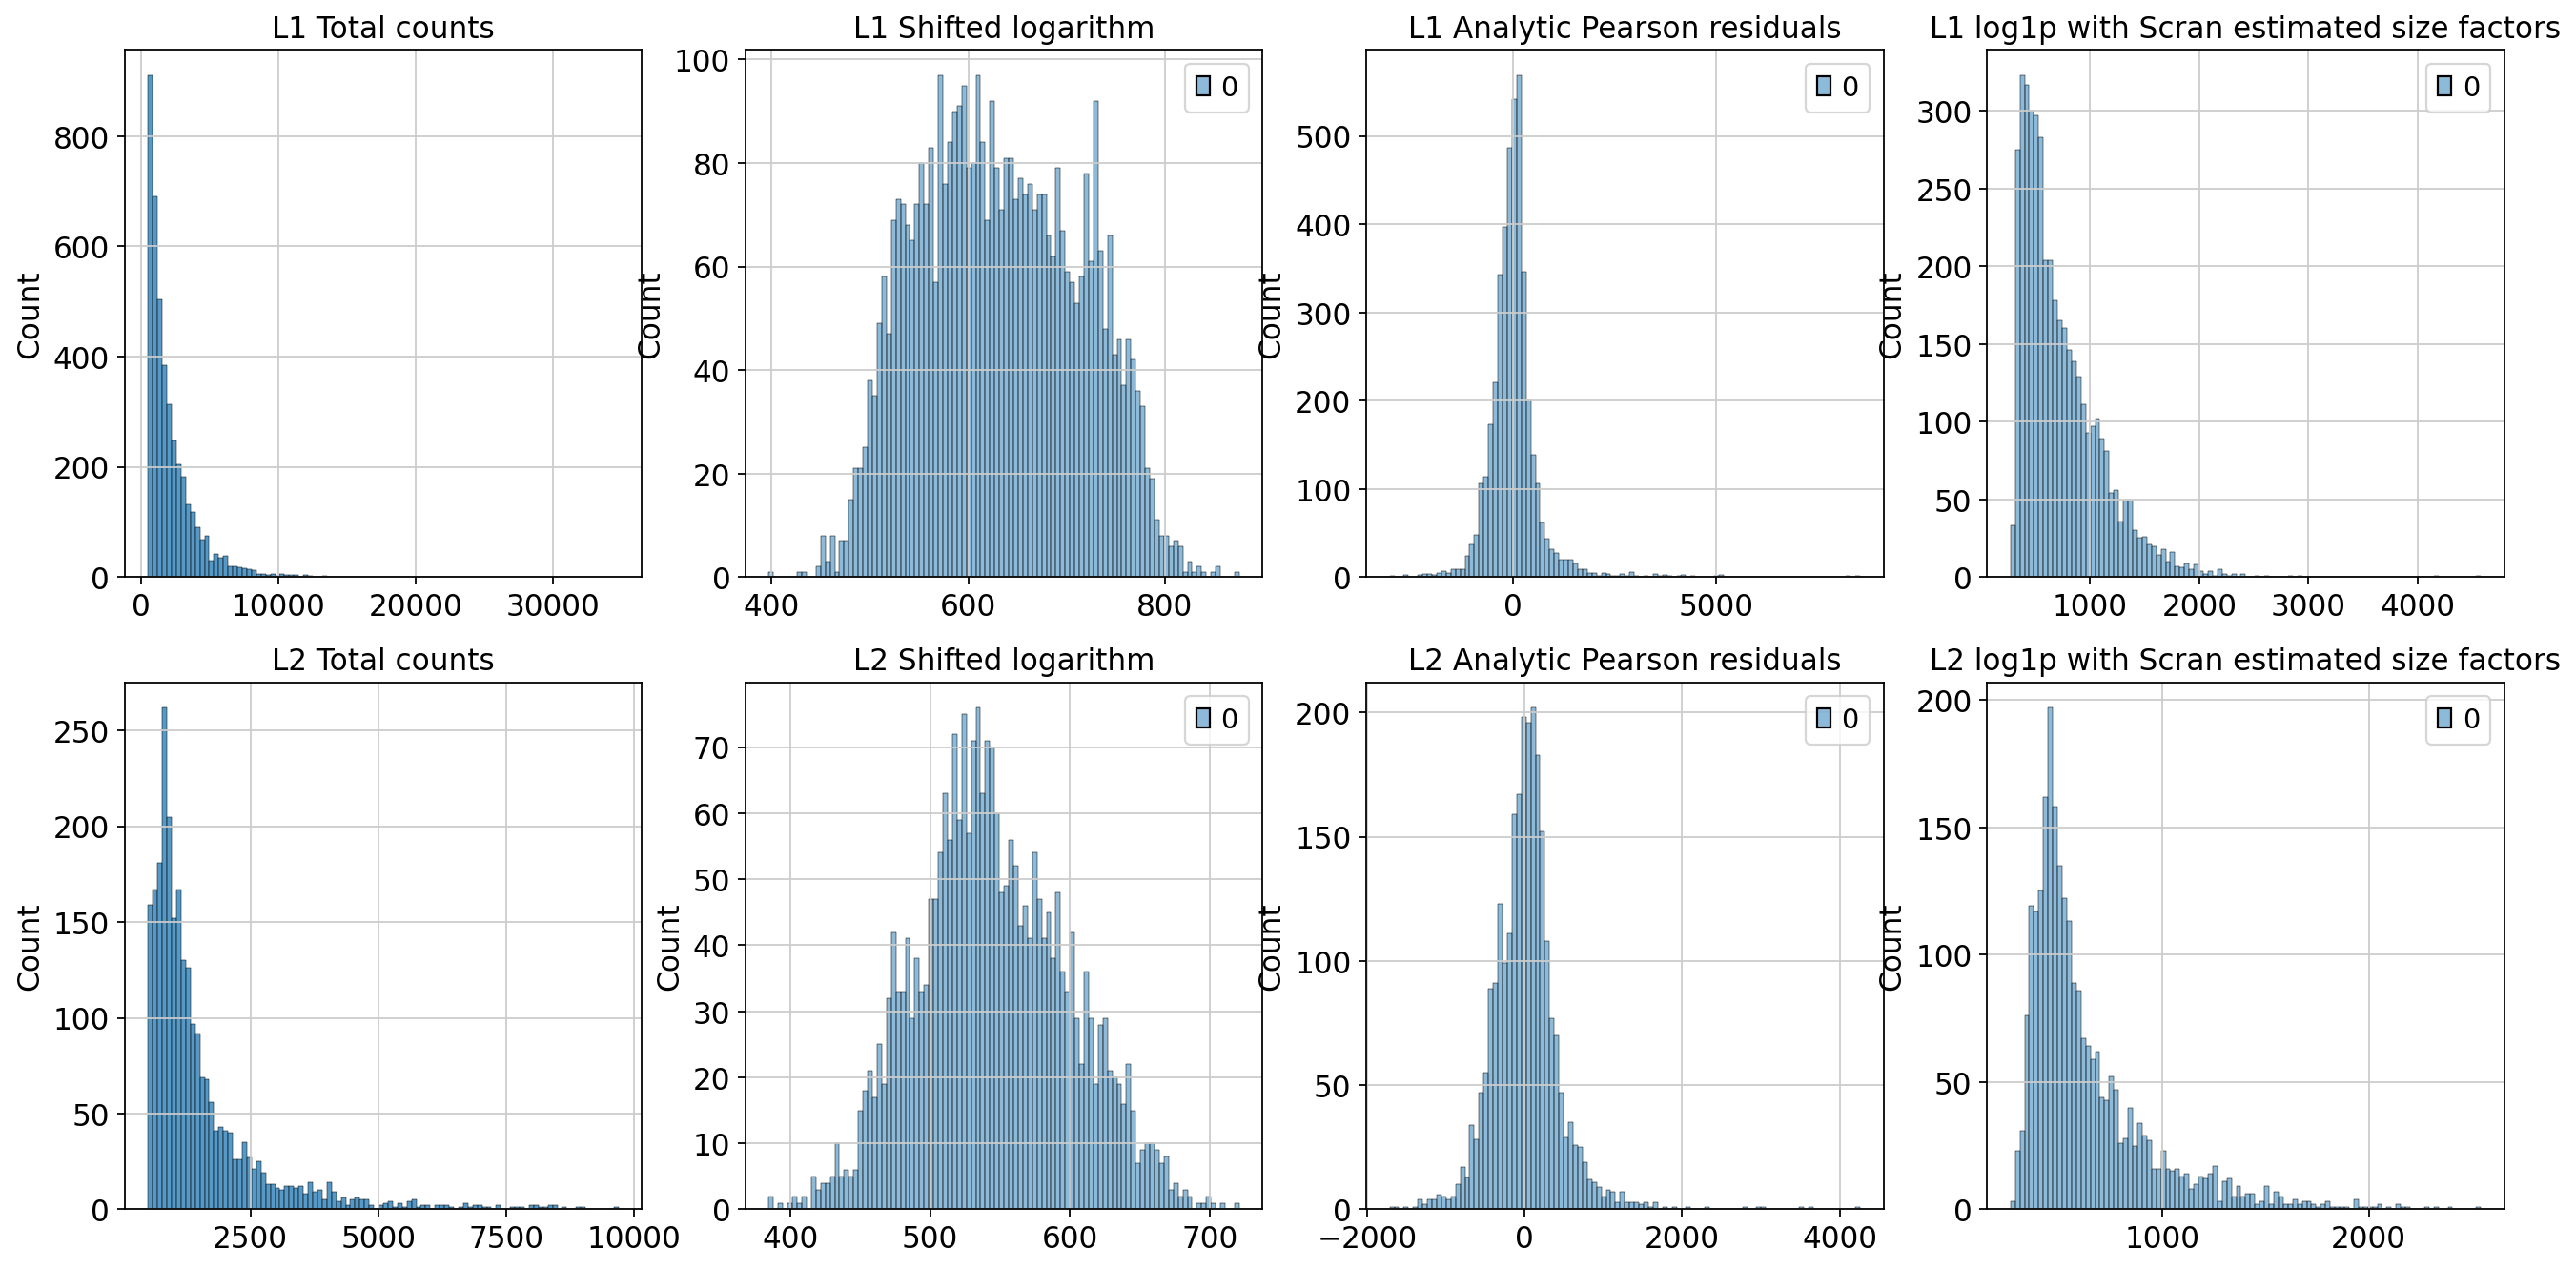

In [146]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

p1 = sns.histplot(l1.obs["total_counts"], bins=100, kde=False, ax=axes[0][0])
axes[0][0].set_title("L1 Total counts")
axes[0][0].set_xlabel('')

p2 = sns.histplot(
    l1.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[0][1]
)
axes[0][1].set_title("L1 Shifted logarithm")

p3 = sns.histplot(
    l1.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[0][2]
)
axes[0][2].set_title("L1 Analytic Pearson residuals")

sns.histplot(
    l1.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[0][3]
)
axes[0][3].set_title("L1 log1p with Scran estimated size factors")

p4 = sns.histplot(l2.obs["total_counts"], bins=100, kde=False, ax=axes[1][0])
axes[1][0].set_title("L2 Total counts")
axes[1][0].set_xlabel('')

p5 = sns.histplot(
    l2.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1][1]
)
axes[1][1].set_title("L2 Shifted logarithm")

p6 = sns.histplot(
    l2.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1][2]
)
axes[1][2].set_title("L2 Analytic Pearson residuals")

sns.histplot(
    l2.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1][3]
)
axes[1][3].set_title("L2 log1p with Scran estimated size factors")

plt.show()

## Check virus

In [147]:
# l1 = sc.read_h5ad(
#     filename="L1_norm.h5ad"
# )
# l2 = sc.read_h5ad(
#     filename="L2_norm.h5ad"
# )

In [148]:
virus_genes = {'TRV': ['TRV-PDS3-transcript', 'pVS1-StaA', 'pVS1-RepA', 'TRV-KanR', 'TRV-dGAG-transcript']}

marker_genes_in_data_l1 = dict()
for ct, markers in virus_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in l1.var.index:
            markers_found.append(marker)
    marker_genes_in_data_l1[ct] = markers_found

marker_genes_in_data_l2 = dict()
for ct, markers in virus_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in l2.var.index:
            markers_found.append(marker)
    marker_genes_in_data_l2[ct] = markers_found

In [149]:
print(marker_genes_in_data_l1) # yay it was not filtered out yet
print(marker_genes_in_data_l2) # yay it was not filtered out yet

{'TRV': ['TRV-PDS3-transcript']}
{'TRV': []}


# Feature selection

In [150]:
import scanpy as sc
import anndata2ri
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%reload_ext rpy2.ipython

In [151]:
%%R
library(scry)

In [153]:
ro.globalenv['l1'] = l1

In [154]:
ro.globalenv['l2'] = l2

In [155]:
%%R
sce_l1 = devianceFeatureSelection(l1, assay="X")
sce_l2 = devianceFeatureSelection(l2, assay="X")

In [156]:
binomial_deviance_l1 = ro.r("rowData(sce_l1)$binomial_deviance").T
binomial_deviance_l2 = ro.r("rowData(sce_l2)$binomial_deviance").T

idx_l1 = binomial_deviance_l1.argsort()[-6000:] # get 6k most deviant genes
mask_l1 = np.zeros(l1.var_names.shape, dtype=bool)
mask_l1[idx_l1] = True

l1.var["highly_deviant"] = mask_l1
l1.var["binomial_deviance"] = binomial_deviance_l1

idx_l2 = binomial_deviance_l2.argsort()[-6000:]
mask_l2 = np.zeros(l2.var_names.shape, dtype=bool)
mask_l2[idx_l2] = True

l2.var["highly_deviant"] = mask_l2
l2.var["binomial_deviance"] = binomial_deviance_l2

sc.pp.highly_variable_genes(l1, layer="scran_normalization")
sc.pp.highly_variable_genes(l2, layer="scran_normalization")

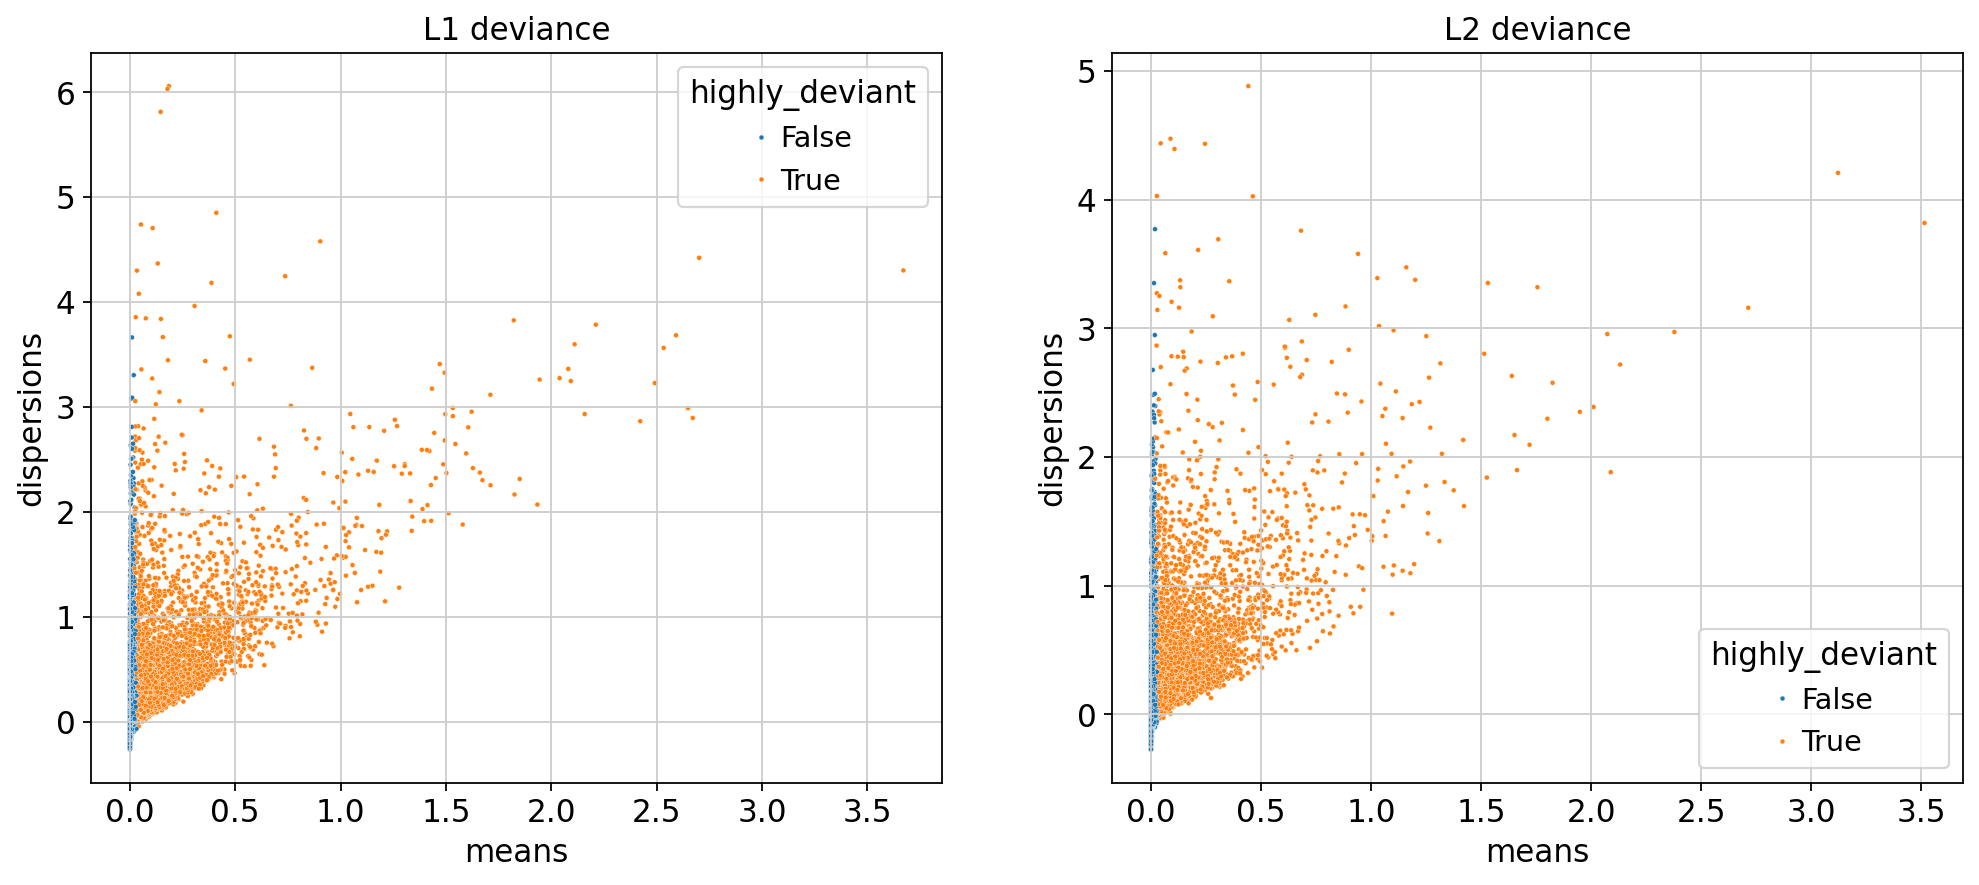

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(
    data=l1.var, x="means", y="dispersions", hue="highly_deviant", s=5, ax=axes[0]
)
#axes[0].set_xlim(None, 1.5)
#axes[0].set_ylim(None, 3)
axes[0].set_title("L1 deviance")


sns.scatterplot(
    data=l2.var, x="means", y="dispersions", hue="highly_deviant", s=5, ax=axes[1]
)
#axes[1].set_xlim(None, 1.5)
#axes[1].set_ylim(None, 3)
axes[1].set_title("L2 deviance")

plt.show()

# Dimensionality reduction

In [158]:
l1.X = l1.layers["log1p_norm"]
l2.X = l2.layers["log1p_norm"]

l1.var["highly_variable"] = l1.var["highly_deviant"]
sc.pp.pca(l1, svd_solver="arpack", use_highly_variable=True)

l2.var["highly_variable"] = l2.var["highly_deviant"]
sc.pp.pca(l2, svd_solver="arpack", use_highly_variable=True)

sc.tl.tsne(l1, use_rep="X_pca")
sc.tl.tsne(l2, use_rep="X_pca")

sc.pp.neighbors(l1)
sc.pp.neighbors(l2)

sc.tl.umap(l1)
sc.tl.umap(l2)

/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


/opt/conda/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


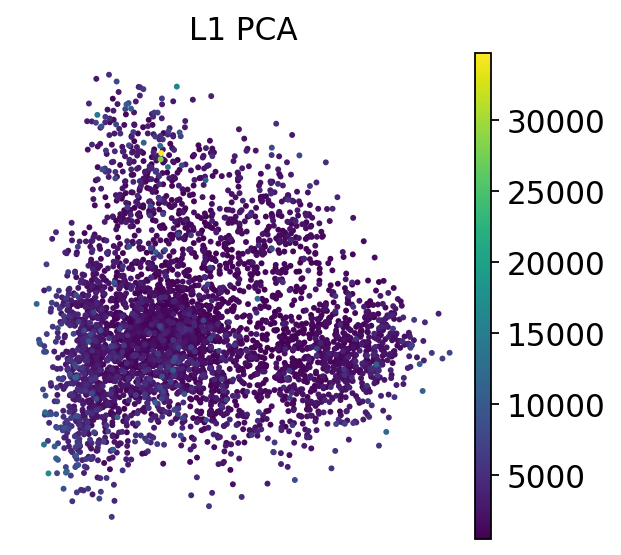

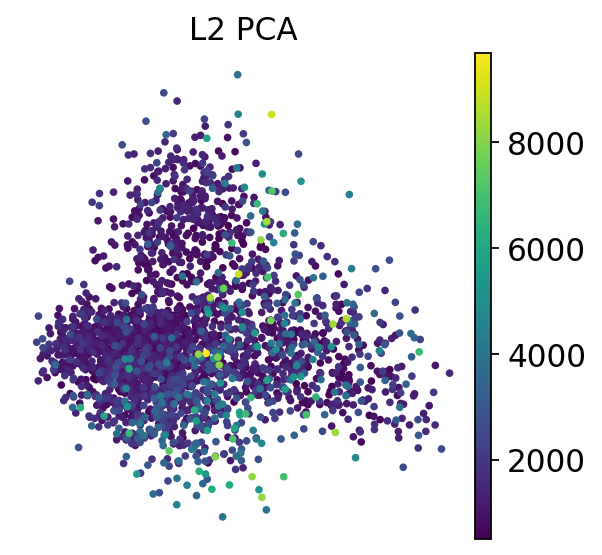

In [159]:
sc.pl.pca_scatter(l1, color="total_counts", title='L1 PCA')

sc.pl.pca_scatter(l2, color="total_counts", title='L2 PCA')

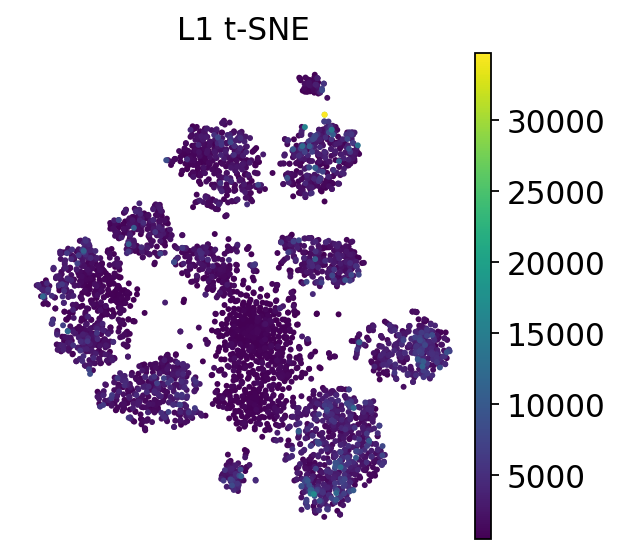

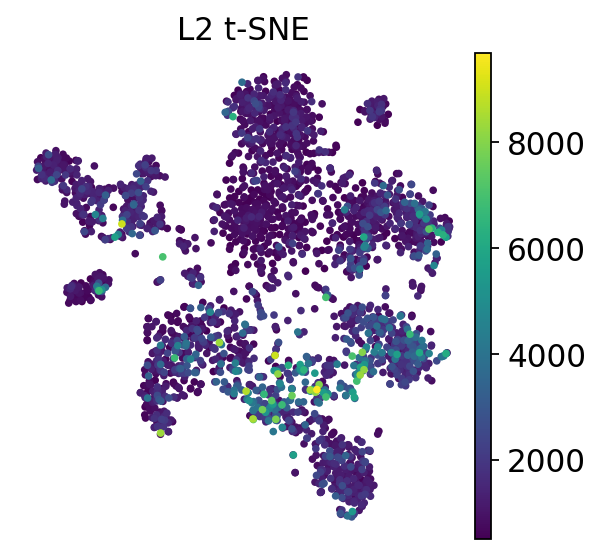

In [160]:

sc.pl.tsne(l1, color="total_counts", title='L1 t-SNE')

sc.pl.tsne(l2, color="total_counts", title='L2 t-SNE')

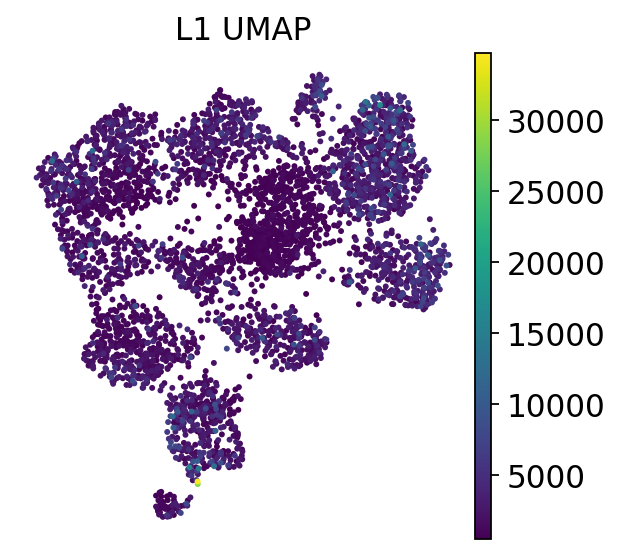

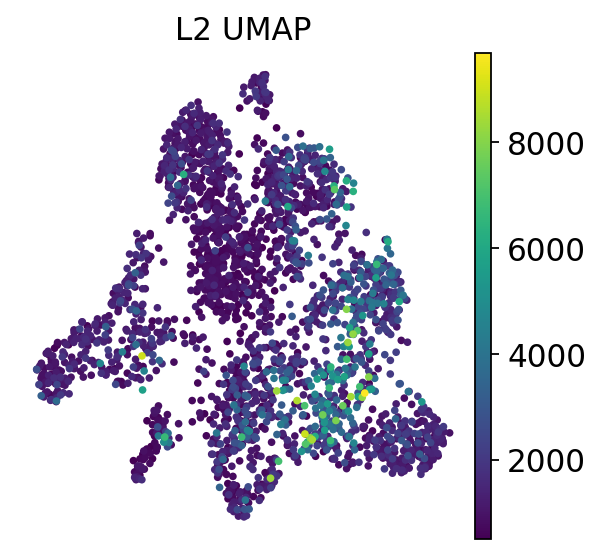

In [161]:
sc.pl.umap(l1, color="total_counts", title='L1 UMAP')

sc.pl.umap(l2, color="total_counts", title='L2 UMAP')

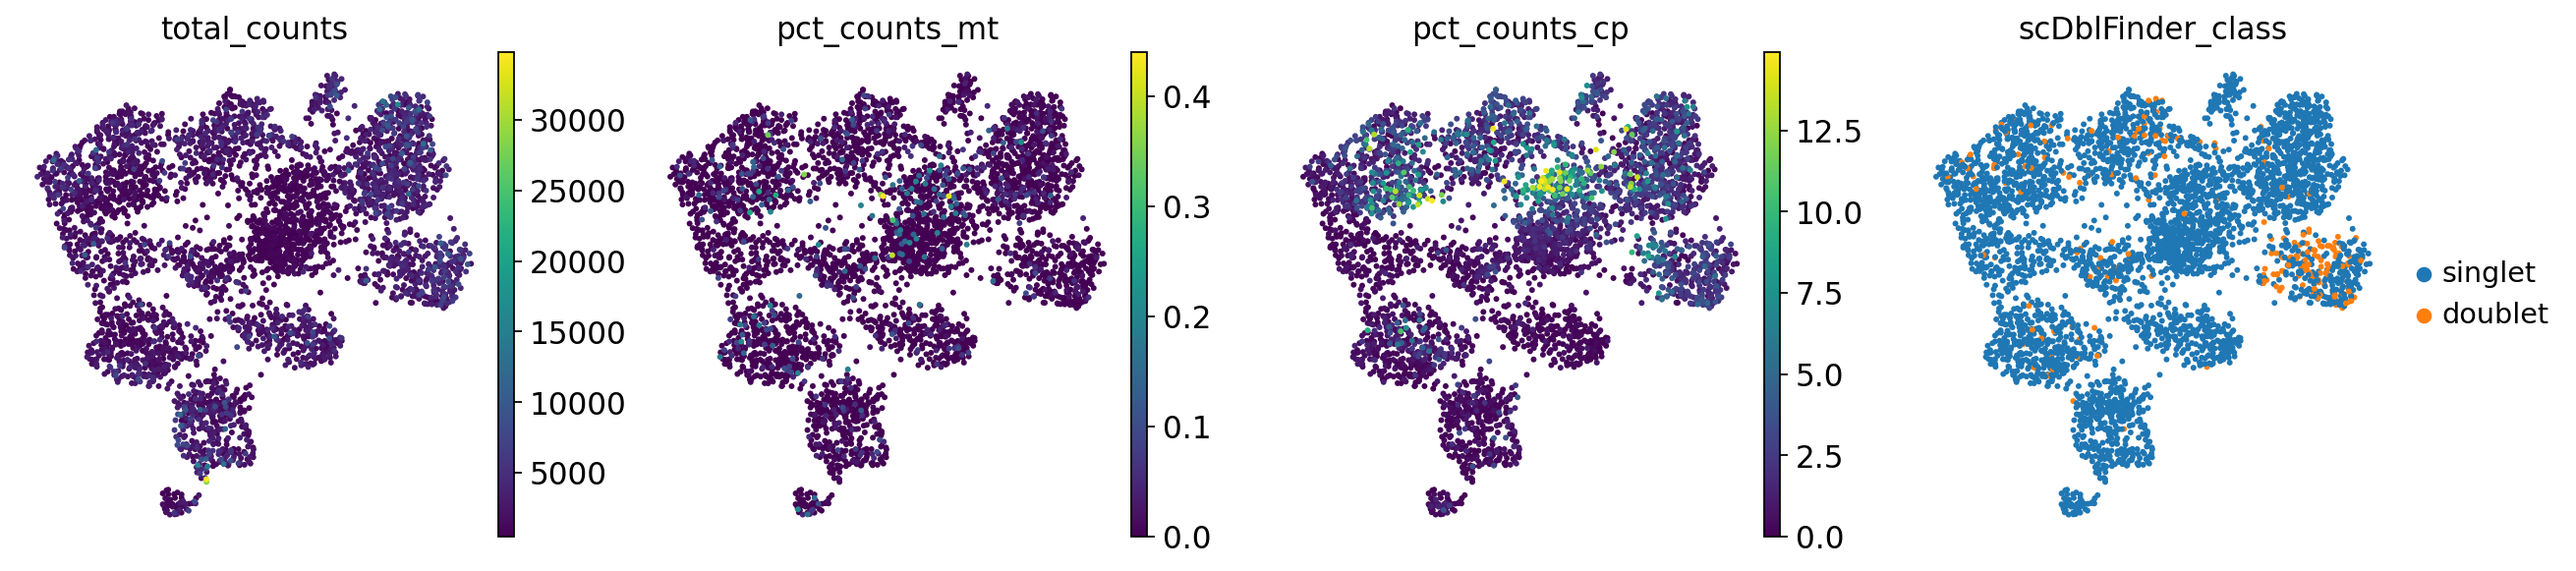

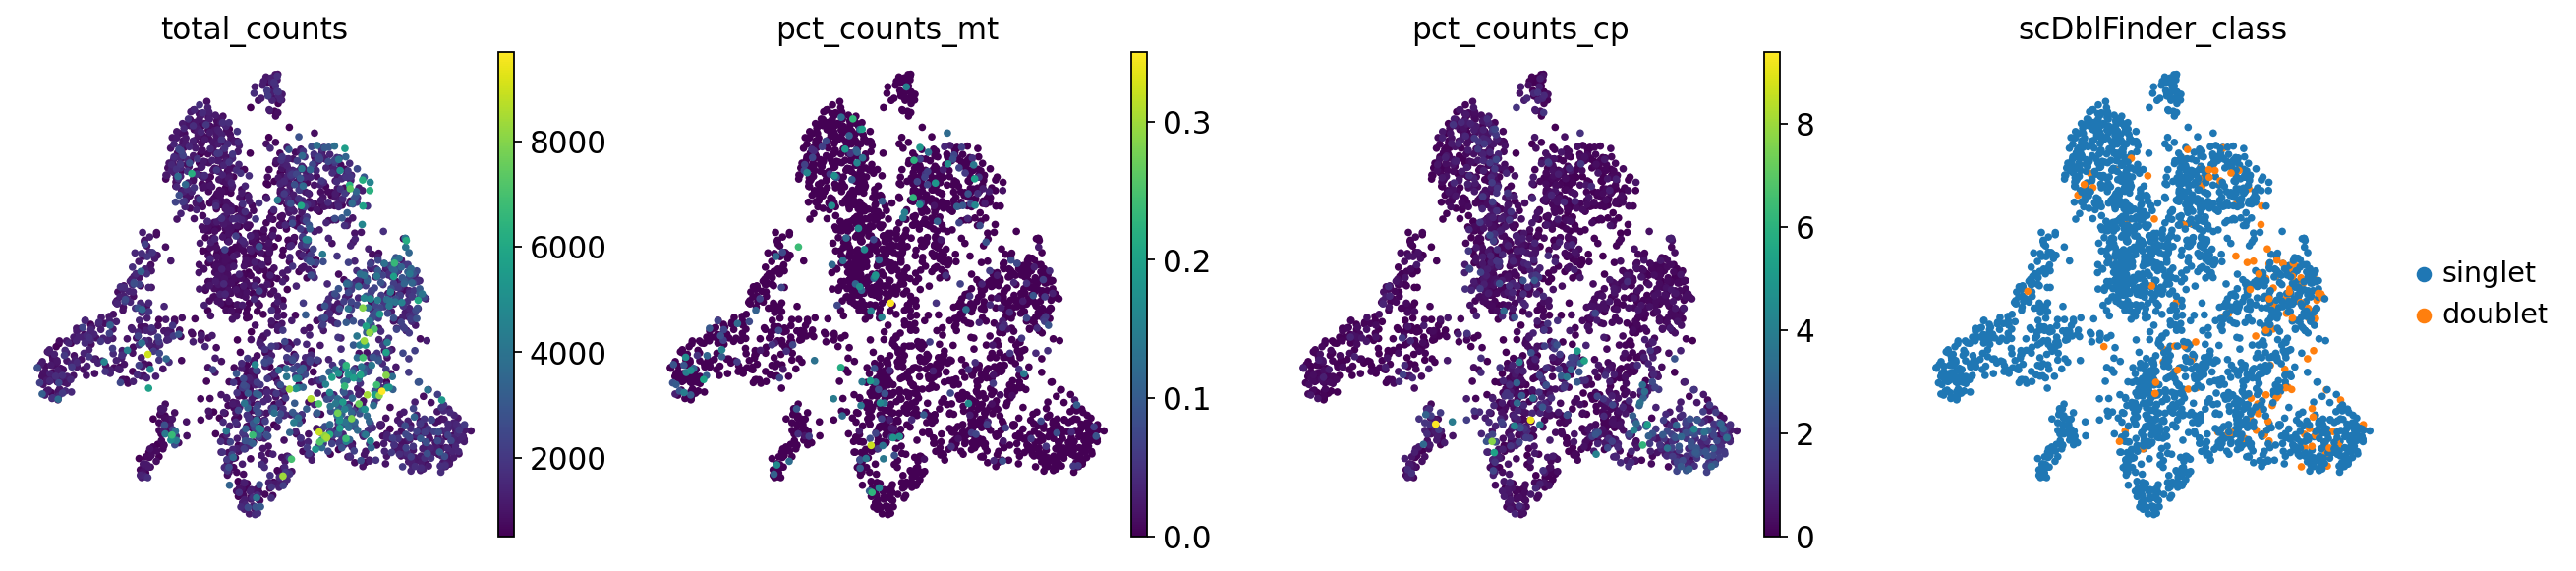

In [162]:
sc.pl.umap(
    l1,
    color=["total_counts", "pct_counts_mt", "pct_counts_cp", "scDblFinder_class"]
)

sc.pl.umap(
    l2,
    color=["total_counts", "pct_counts_mt", "pct_counts_cp", "scDblFinder_class"]
)

In [163]:
l1.write("L1_dimensionality_reduction.h5ad")
l2.write("L2_dimensionality_reduction.h5ad")

# Clustering

In [164]:
sc.pp.neighbors(l1, n_pcs=30)
sc.pp.neighbors(l2, n_pcs=30)

sc.tl.umap(l1)
sc.tl.umap(l2)

In [165]:
sc.tl.leiden(l1, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(l1, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(l1, key_added="leiden_res1", resolution=1.0)

sc.tl.leiden(l2, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(l2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(l2, key_added="leiden_res1", resolution=1.0)

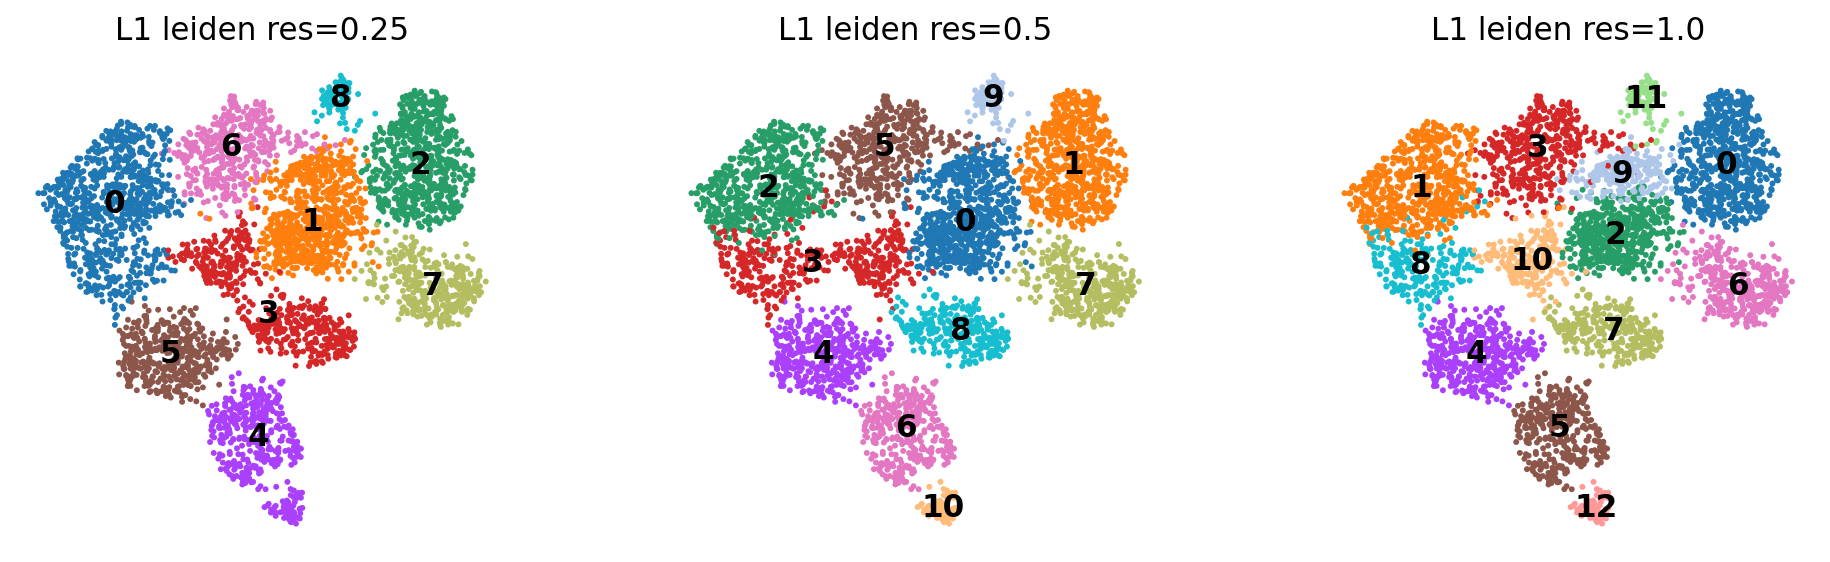

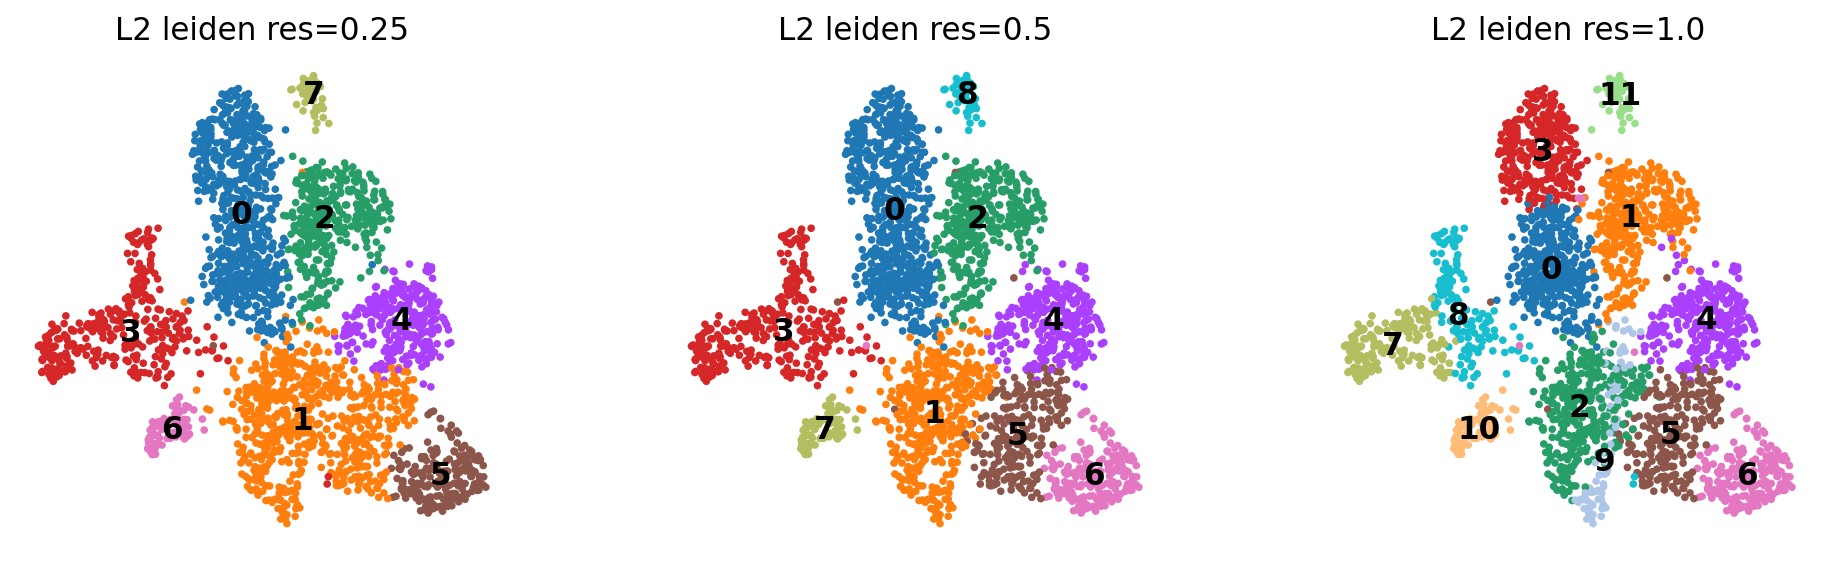

In [166]:
sc.pl.umap(
    l1,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
    title=['L1 leiden res=0.25', 'L1 leiden res=0.5', 'L1 leiden res=1.0']
)

sc.pl.umap(
    l2,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
    title=['L2 leiden res=0.25', 'L2 leiden res=0.5', 'L2 leiden res=1.0']
)

In [167]:
l1.write("L1_clustering.h5ad")
l2.write("L2_clustering.h5ad")